In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy

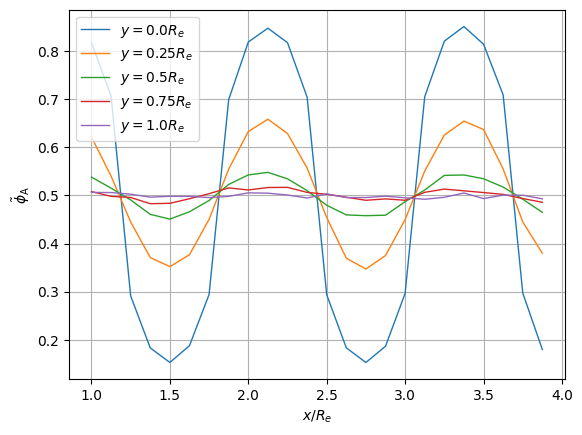

In [2]:
offset=1


plt.figure(dpi=100)
plt.grid()
def plot_conversion_range(y,dir):
    """plot Amplitude as a function of y
    """
    with h5py.File(f'{dir}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
        with h5py.File(f'{dir}/coord_ana.h5', 'r') as f:
            #only load every other frame, the others are not optimized
            phi=np.array(f['density_field'])

    #only every other frame is optimized
    phi=phi[1::2]
    #average phi over time
    phi=phi.mean(axis=0)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,area51==0].reshape(phi.shape[0],nxyz[0],nxyz[1],nxyz[2])
    phi_tot=np.sum(phi,axis=0)
    #phi_tot[phi_tot==0]=1
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    composition=deepcopy(phi)
    for j in range(2):
        composition[j]/=phi_tot
    #get phi and composition at y value where umbrella field is defined averaged over z
    composition_mean=composition[:,:,y,:].mean(axis=2)
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    amplitude=np.max(composition_mean[0][8:-8])
    if y%2==0:
        plt.plot(l_plot[8:-8],composition_mean[0][8:-8],lw=1,label="$y=$"+f"{dxyz[0]*i}"+"$R_e$")
    return amplitude
amplitudes=np.empty(0)
ys=np.arange(0,10,1)
for i in ys:
    amplitudes=np.append(amplitudes,plot_conversion_range(i,"dphi0.5"))
plt.xlabel("$x/R_e$")
plt.ylabel(r"$\tilde\phi_\mathrm{A}$")
plt.legend()
plt.savefig("amplitude_decay_profile.pdf")
plt.show()






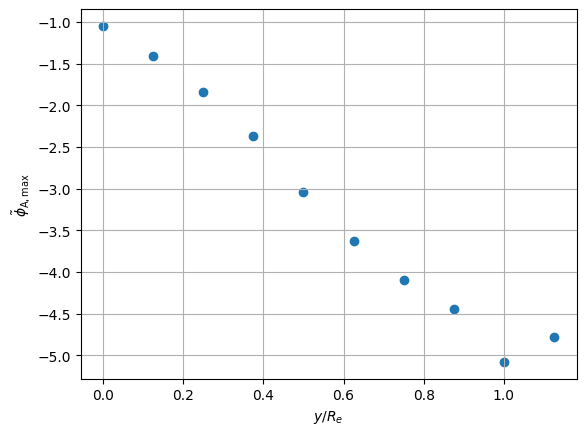

In [4]:
plt.figure(dpi=100)
plt.grid()
plt.xlabel("$y/R_e$")
plt.ylabel(r"$\tilde\phi_\mathrm {A, max}$")
plt.scatter(ys*0.125,np.log(amplitudes-0.5))
plt.savefig("ampltitude_decay.pdf")